In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import *
import multiprocessing as mp
import h5py
import logging
from math import floor
from tqdm.notebook import tqdm
import torch

In [2]:
# Biopython creates warnings for chains that are discontinuous. I recommend turning them off.
import warnings
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

In [3]:
#logging.basicConfig(filename='/home/menanagy/Downloads/protein_gan_master/data/mydata/data_generation.log',level=logging.ERROR)2

In [4]:
#Global Variables
#----------------
# Requires absolute path
train_path = pathlib.Path("/trainPath/")

In [5]:
def split_matrix(matrix):
    if (len(matrix)>=RES):
        for n in range(1,int(floor(len(matrix)/RES))):
            # Creating RES x RES matrices by traversing the spine of input matrix
            matrix_chunk = matrix[RES*(n-1):RES*n, RES*(n-1):RES*n]
            yield matrix_chunk

In [6]:
def calc_dist_matrix(residues):
    """Returns a matrix of distances between residues of the same chain."""
    size = len(residues)
    answer = np.zeros((size, size), np.float)
    for row, residue_one in enumerate(residues):
        for col, residue_two in enumerate(residues):
            answer[row, col] = residue_one["CA"] - residue_two["CA"]            
    return answer

In [7]:
def generate_maps(files):
    """
    Generate specified resolution a-carbon maps given a input directory
    """
    # Create A chain maps as matrices
    parser = PDBParser()
    io = PDBIO()
    # Get the initial structure of the protein
    try:    
        structure = parser.get_structure('X', files)
        for models in structure:
            residues = Selection.unfold_entities(models['A'], 'R')
            ca_residues = [residue for residue in residues if 'CA' in residue]
            distance_matrix = calc_dist_matrix(ca_residues)
            return list(split_matrix(distance_matrix))
    except ValueError as err:
        logging.error(f'ValuError file :{files}, Error is:{err}')
    except TypeError as err:
        logging.error(f'TypeError file :{files}, Error is:{err}')


In [8]:

def main(files, desc):
    """
    Clean the generated maps using all cores in the process
    """
    p = mp.Pool(maxtasksperchild=3)
    pdbs = [file for file in files.glob("*.pdb")]
    r = list(tqdm(p.imap(generate_maps, pdbs), total=len(pdbs), desc=desc))
    p.close()
    p.join()
    return r

In [9]:
def test(result):
    test_len = [len(x) for x in result]
    plt.hist(test_len)
    plt.show()
    plt.imshow(result[5], cmap='viridis')
    plt.colorbar()
    plt.show()

In [ ]:
RES =64
train_64 = main(train_path, "train_64")
train_64 = [item for sublist in train_64 if sublist for item in sublist]
with h5py.File('dataset.hdf5', 'a') as f:
    f.create_dataset('train_64', data=train_64, compression="gzip")

In [ ]:
RES = 128
train_128 = main(train_path, "train_128")
train_128 = [item for sublist in train_128 if sublist for item in sublist]
with h5py.File('dataset.hdf5', 'a') as f:
    f.create_dataset('train_128', data=train_128, compression="gzip")

In [ ]:
RES =256
train_256 = main(train_path, "train_256")
train_256 = [item for sublist in train_256 if sublist for item in sublist]
with h5py.File('dataset.hdf5', 'a') as f:
    f.create_dataset('train_256', data=train_256, compression="gzip")

In [75]:
train_128[0].shape

(128, 128)

<AxesSubplot:>

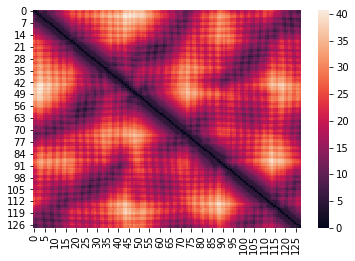

In [76]:
import seaborn as sns
sns.heatmap(train_128[0])